In [76]:
import pandas as pd
from astroquery.gaia import Gaia
from typing import List
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.time import Time
from astropy.timeseries import BoxLeastSquares, TimeSeries

In [64]:
def download_lightcurves(source_ids: np.ndarray) -> List[pd.DataFrame]:
    retrieval_type = 'ALL'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
    data_structure = 'INDIVIDUAL'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
    data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'

    
    lightcurves: List[pd.DataFrame] = []

    datalink = Gaia.load_data(ids=source_ids,
                              data_release = data_release,
                              retrieval_type= 'EPOCH_PHOTOMETRY',
                              data_structure = data_structure,
                              verbose = False, output_file = None)
    dl_keys  = [inp for inp in datalink.keys()]
    dl_keys.sort()

    print(f'{len(dl_keys)} lightcurves found.')
    for dl_key in dl_keys:
        print(f'\tDownloading {dl_key}')
        lightcurves.append(datalink[dl_key][0].to_table().to_pandas())
        
    return lightcurves

In [60]:
def vari_short_timescale(source_ids: np.ndarray) -> pd.DataFrame:
    query = f'''
        SELECT * 
        FROM gaiadr3.vari_short_timescale 
        WHERE vari_short_timescale.source_id IN ({', '.join([str(si) for si in source_ids])})
    '''
    
    job = Gaia.launch_job_async(query, output_format='csv')
    
    return job.get_results().to_pandas()

In [54]:
bss_candidates = pd.read_csv('bss_candidates.csv')

In [22]:
yss_candidates = pd.read_csv('yss_candidates.csv')

# BSS candidates

In [65]:
bss_phot = bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']
bss_lightcurves = download_lightcurves(bss_phot.source_id.values)

2 lightcurves found.


In [61]:
short_timescale_info = vari_short_timescale(bss_phot.source_id.values)

INFO: Query finished. [astroquery.utils.tap.core]


In [62]:
short_timescale_info

,solution_id,source_id,amplitude_estimate,number_of_fov_transits,mean_of_fov_abbe_values,variogram_num_points,variogram_char_timescales,variogram_values,frequency
0,375316653866487564,573944283722429952,0.070808,45,1.00579,1,(0.176),(0.0023709204660254096),32.39746


In [66]:
bss2_lc = bss_lightcurves[1]

In [68]:
bss2_lc.head()

,source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
0,573968576057423360,16794185389056965,G,1700.557482,13.258732,93638.382788,97.088994,964.459290,False,False,1,375316653866487564
1,573968576057423360,16798277678981731,G,1700.631492,13.248248,94546.930254,87.650003,1078.687134,False,False,1,375316653866487564
2,573968576057423360,18920283006998245,G,1739.008450,13.239307,95328.747046,80.869795,1178.792969,False,False,1,375316653866487564
3,573968576057423360,18930023819277864,G,1739.184614,13.238245,95422.013248,70.423744,1354.969360,False,False,1,375316653866487564
4,573968576057423360,21028967752677174,G,1777.144090,13.242362,95060.910439,180.323169,527.169678,False,False,4097,375316653866487564


<ErrorbarContainer object of 3 artists>

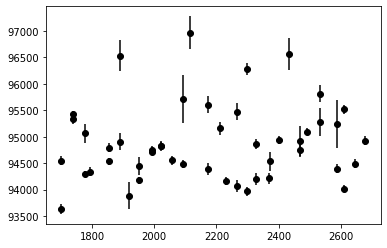

In [70]:
g_mag = bss2_lc[bss2_lc.band=='G']

plt.errorbar(x=g_mag.time, y=g_mag.flux, yerr=g_mag.flux_error, color='black', fmt='o')

In [79]:
model = BoxLeastSquares(g_mag.time.values*u.day, g_mag.flux.values)

In [86]:
periodogram = model.autopower(0.1)

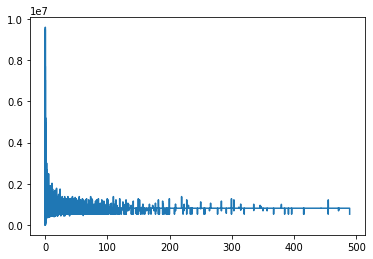

In [87]:
plt.figure();
plt.plot(periodogram.period, periodogram.power)

In [40]:
yss_candidates.non_single_star

0     0
1     0
2     2
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    2
13    0
Name: non_single_star, dtype: int64

In [23]:
len(yss_candidates)

14

In [38]:
bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,A_z,A_y,A_J,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,outlier
22,1636148068921376768,Gaia DR3 573944283722429952,573944283722429952,1692006547,2016.0,10.849436,0.017361,85.342409,0.01773,0.512738,...,0.432171,0.352377,0.221163,0.130851,0.084425,0.638973,0.005293,3.306617,0.078882,-1
24,1636148068921376768,Gaia DR3 573968576057423360,573968576057423360,619651974,2016.0,11.089231,0.013633,85.441673,0.01292,0.540633,...,0.432171,0.352377,0.221163,0.130851,0.084425,0.324245,0.001706,1.680547,0.057213,-1


In [30]:
rv = yss_candidates.dropna(subset=['rv_amplitude_robust'])

In [32]:
rv.rv_

7

In [31]:
list(yss_candidates.columns)

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_sigma5d_max

In [33]:
rv_yss = yss_candidates[yss_candidates.rv_amplitude_robust>=6*yss_candidates.radial_velocity_error]

In [47]:
rv.rv_amplitude_robust

0      4.301125
2     40.335930
4      4.961807
9      4.703495
10     3.705101
12    11.476746
13     7.787983
Name: rv_amplitude_robust, dtype: float64

In [48]:
rv.radial_velocity_error

0     0.356694
2     4.703893
4     0.323615
9     0.374134
10    0.373820
12    1.227304
13    0.503927
Name: radial_velocity_error, dtype: float64

In [49]:
rv.rv_renormalised_gof

0     -0.124132
2     38.806580
4     -0.698303
9     -0.135582
10    -1.525915
12    11.324680
13    -1.295523
Name: rv_renormalised_gof, dtype: float64